<p style = 'font-size:40px'> <strong> ENEM Data Analysis</strong> </p>

<p style = 'font-size:30px'> <strong>Introduction</strong> </p>

* <p style = 'font-size:20px'> The goal of this project is to analyze the ENEM 2019 edition microdata.</p>

* <p style = 'font-size:20px'> ENEM is a national High School exam annually applied by Brazil's federal government. It aims assessing the performance of the country's students relating to subjects ranging from text production to math problems resolution.</p>

* <p style = 'font-size:20px'> After ENEM occurs, the Education Ministry is responsible for compiling the informations of every single participant into a csv file.</p>

<p style = 'font-size:30px'> <strong> What we are looking to achieve in this project</strong> </p>

* <p style = 'font-size:20px'> I've conceived five tasks to be carried out:</p>

<p style = 'font-size:20px; margin-left:40px'> 1) Plot a detailed chart representing how the candidates performed in both of the exam's days.</p>

<p style = 'font-size:20px; margin-left:40px'> 2) See if there is any correlation between the redaction grades and the illiteracy levels from Brazil's states.</p>

<p style = 'font-size:20px; margin-left:40px'> 3) Compare the ENEM performance among the private and public schools across the country.</p>

<p style = 'font-size:20px;margin-left:40px'> 4) Check if the students who live in states' capital cities outperform the ones who live in the rural area</p> 

<p style = 'font-size:20px;margin-left:40px'> 5) Display the participants average performance accordingly to their economic class.</p>

<p style = 'font-size:30px'> <strong>Data set presentation</strong> </p>

<div style = 'font-size:20px'>
    <ul>
        <li>The file we are about to open is way too heavy to be accessed by pandas usual methods. Its size is more than 3 GB and we won't be able to use the well-known <em>read_csv</em> method without receiving a <em>MemoryError</em>.</li>
        <li> Our strategy therefore is going to be converting all the csv data into an SQL database table!</li>

In [3]:
# Creating our internal database with sqlite3 and sqlalchemy.
import sqlite3
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
csv_database = create_engine('sqlite:///csv_database.db')

# Inserting ENEM's microdata into the database.
for chunk in pd.read_csv('MICRODADOS_ENEM_2019.csv',encoding = 'ISO-8859-1', 
                         sep = ';', chunksize = 50000, iterator = True):
    chunk.to_sql('enem', csv_database, if_exists = 'append')

In [361]:
# And now, the informations will be pulled from the database through the use of the read_sql method!
# To enhance the speed of the DataFrame receipt, we'll only list the columns that we'll be of use in the project. 
query = ''' SELECT NU_INSCRICAO, NO_MUNICIPIO_RESIDENCIA, SG_UF_RESIDENCIA, TP_ST_CONCLUSAO, 
            TP_ESCOLA, TP_PRESENCA_CN, TP_PRESENCA_CH, NU_NOTA_LC, NU_NOTA_CH,NU_NOTA_MT,
            NU_NOTA_CN, NU_NOTA_REDACAO, Q006
            FROM ENEM'''
enem = pd.read_sql(query, csv_database)

# Here, I'll let you take a look in the data we've obtained.
enem.head()

,NU_INSCRICAO,NO_MUNICIPIO_RESIDENCIA,SG_UF_RESIDENCIA,TP_ST_CONCLUSAO,TP_ESCOLA,TP_PRESENCA_CN,TP_PRESENCA_CH,NU_NOTA_LC,NU_NOTA_CH,NU_NOTA_MT,NU_NOTA_CN,NU_NOTA_REDACAO,Q006
0,190001595656,Sorocaba,SP,1,1,0,0,NaN,NaN,NaN,NaN,NaN,A
1,190001421546,Feira de Santana,BA,1,1,0,0,NaN,NaN,NaN,NaN,NaN,C
2,190001133210,Fortaleza,CE,1,1,0,0,NaN,NaN,NaN,NaN,NaN,B
3,190001199383,Palmas,TO,1,1,1,1,537.3,503.6,392.0,483.8,460.0,E
4,190001237802,Contagem,MG,1,1,1,1,570.7,575.5,677.0,513.6,860.0,G


<div style = 'font-size:30px'>
    <p> <strong>Data Cleaning </strong></p>
    </div>
    
 <div style = 'font-size:20px'>
    <ul>
        <li> When thinking about a data set over individuals who have taken a test, the first thing we ought to consider is that not all candidates showed up when it was applied. As this project is focused primarily on performance, the absent people have no use.</li>
    </ul>
    </div>
    

In [368]:
# Here, we are filtering out the people who did not taken the first or second day of ENEM.
enem = enem[(enem['TP_PRESENCA_CN'] == 1) & (enem['TP_PRESENCA_CH'] == 1)]

# Another useful procedure to be conducted is the grades normalization. Unlike other tests you may have taken, ENEM 
# assesses the student grades based on how they performed in comparison to others in each subject.
def min_max(column):
    return (column - column.min()) / (column.max() - column.min())

enem[['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']] = (enem[
                                                                            ['NU_NOTA_CN', 'NU_NOTA_CH',
                                                                            'NU_NOTA_LC', 'NU_NOTA_MT',
                                                                             'NU_NOTA_REDACAO']].apply(min_max))

# Creating a new column displaying the candidates average performance.
enem['Avg Grade'] = enem[['NU_NOTA_LC', 'NU_NOTA_CH', 'NU_NOTA_MT', 'NU_NOTA_CN', 'NU_NOTA_REDACAO']].mean(axis = 1)

enem.head()

,NU_INSCRICAO,NO_MUNICIPIO_RESIDENCIA,SG_UF_RESIDENCIA,TP_ST_CONCLUSAO,TP_ESCOLA,TP_PRESENCA_CN,TP_PRESENCA_CH,NU_NOTA_LC,NU_NOTA_CH,NU_NOTA_MT,NU_NOTA_CN,NU_NOTA_REDACAO,Q006,Avg Grade
3,190001199383,Palmas,TO,1,1,1,1,0.670201,0.603042,0.397768,0.561970,0.46,E,0.538596
4,190001237802,Contagem,MG,1,1,1,1,0.711862,0.689139,0.686961,0.596585,0.86,G,0.708909
5,190001782198,Rondonópolis,MT,1,1,1,1,0.703755,0.772243,0.685236,0.654780,0.80,E,0.723203
6,190001421548,Paulo Afonso,BA,1,1,1,1,0.632656,0.584840,0.603450,0.562899,0.60,B,0.596769
9,190001592266,São Paulo,SP,2,2,1,1,0.626793,0.656329,0.487773,0.631781,0.40,F,0.560535


<div>
<p style = 'font-size:30px'> <strong>Task 1</strong> </p>
    </div>
    
<div>
    <ul>
        <li style = 'font-size:20px'> ENEM is applied in two different days. The first one is when the Portuguese and Human Sciences tests occur; in the second day the students need to solve Math and Nature Sciences questions.</li>
        <li style = 'font-size:20px'>We can observe how well students were in both of those days by plotting a scatter plot. The x-axis and y-axis will show the grade of the subjects from each ENEM's days.</li>
    </ul>
    </div>

In [369]:
# In this task, we are about to make something quite unusual for most of the matplotlib productions you may have seen.
# To plot the data, we are going to make use of the library's gridspec.GridSpec object.
# We'll create two histograms along the scatter plot as a tool to assist the data visualization.
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import PercentFormatter

# Making a function for the chart. The arguments are the DataFrame, the columns to be referred and the chart's axes
                                                                                                    # labels.
def grid(df, column1, column2, label1, label2):
    plt.figure(figsize = (10,6.5))
    
    # Creating the gridspec.GridSpec with 4 rows and 4 columns
    gspec = gridspec.GridSpec(4, 4, wspace = 0, hspace = 0)
    
    # Defining the spaces to be filled by the charts.
    scatter = plt.subplot(gspec[:3, 1:])
    bottom_histogram = plt.subplot(gspec[3, 1:], sharex = scatter)
    left_histogram = plt.subplot(gspec[0:3, 0], sharey = scatter)

    # Setting the configurations needed to our scatter plot.
    scatter.scatter(df[column1], enem[column2], s = 0.1, c = '#0e2f44' , alpha = 1)
    scatter.xaxis.tick_top()
    scatter.yaxis.tick_right()
    scatter.spines['left'].set_visible(False)
    scatter.spines['bottom'].set_visible(False)
    scatter.set_xlabel(label1)
    scatter.set_ylabel(label2, rotation = 270, labelpad = 20)
    scatter.xaxis.set_label_position('top') 
    scatter.yaxis.set_label_position('right')
    # Here, I am plotting two lines indicating the average score for both of the subjects being analyzed.
    scatter.axvline(np.mean(df[column1]), lw = 0.5, color = 'purple')
    scatter.axhline(np.mean(df[column2]), lw = 0.5, color = 'purple')
    scatter.set_xlim(0.250,1)
    scatter.set_ylim(0.250,1)

    # Setting the configurations needed to our bottom histogram plot.
    bottom_histogram.hist(df[column1], bins = 100, color = 'gold', alpha = 0.3)
    bottom_histogram.yaxis.tick_right()
    bottom_histogram.invert_yaxis()
    bottom_histogram.xaxis.tick_bottom()
    bottom_histogram.spines['top'].set_visible(False)
    bottom_histogram.spines['left'].set_visible(False)
    bottom_histogram.set_xlabel(label1)
    bottom_histogram.set_ylabel('Thousands', rotation = 270, labelpad = 15)
    bottom_histogram.yaxis.set_label_position('right')
    ytick_labels = [f'{int(number)}' for number in bottom_histogram.get_yticks() / 1000]
    bottom_histogram.set_yticklabels(ytick_labels)

    # Setting the configurations needed to the left histogram.
    left_histogram.hist(df[column2], bins = 100, orientation = 'horizontal', color = 'gold', alpha = 0.3)
    left_histogram.invert_xaxis()
    left_histogram.spines['right'].set_visible(False)
    left_histogram.spines['bottom'].set_visible(False)
    left_histogram.xaxis.tick_top()
    left_histogram.set_ylabel(label2)
    left_histogram.xaxis.set_label_position('top')
    left_histogram.set_xlabel('Thousands')
    left_histogram.yaxis.set_label_position('left')
    xticks_labels = [f'{int(number)}' for number in left_histogram.get_xticks() / 1000]
    left_histogram.set_xticklabels(xticks_labels )


<ipython-input-369-878b758ac6a3>:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  bottom_histogram.set_yticklabels(ytick_labels)
<ipython-input-369-878b758ac6a3>:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  left_histogram.set_xticklabels(xticks_labels )


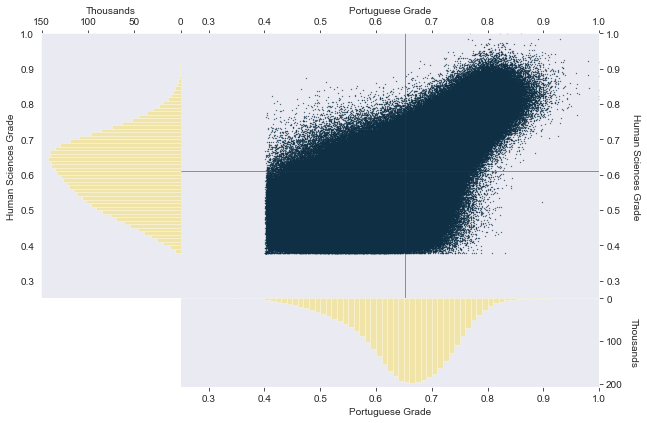

In [370]:
grid(enem, 'NU_NOTA_LC', 'NU_NOTA_CH', 'Portuguese Grade', 'Human Sciences Grade');

<ipython-input-369-878b758ac6a3>:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  bottom_histogram.set_yticklabels(ytick_labels)
<ipython-input-369-878b758ac6a3>:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  left_histogram.set_xticklabels(xticks_labels )


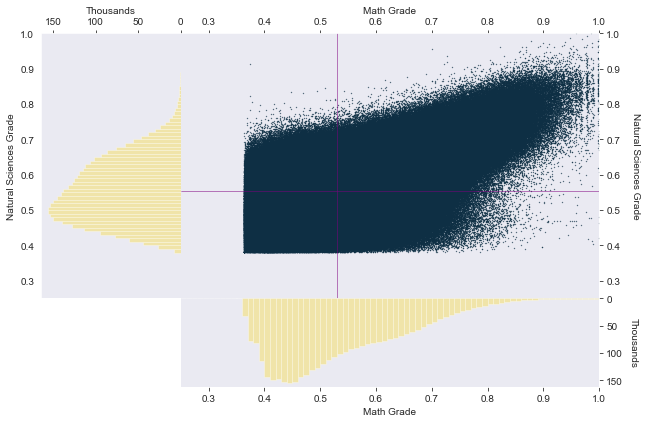

In [371]:
grid(enem , 'NU_NOTA_MT', 'NU_NOTA_CN', 'Math Grade', 'Natural Sciences Grade')

<div>
    <ul style = 'font-size:20px'>
        <li> What you've just seen are two scatter plots holding performance data from all ENEM candidates in both of the exam's days. On the left and bottom of the main graph, there are two histograms showing us the frequency of scores in thousands of students. The vertical and horizontal lines expose the mean grades for both of the subjects of the x and y axes. Note how all the informations dialogue with each other.</li>
        
    </ul>
    </div>

<div>
    <h1> <strong>Task 2</strong>
    </h1>
    </div>
    
    
<div>
    <ul style = 'font-size:20px'>
        <li> One of the main challenges Brazil has been facing in the last decades in terms of education is handling the illiteracy levels among its population. Although many advancements were made, this topic still has plenty of relevance in the country's public debate. 
        </li>
        
        <li>
            What we are expecting here is to see if there is any relation between the states average composition grades and their illiteracy indices.
        </li>
    
    </div>

In [372]:
# Calling out the file with the illiteracy levels.
illiteracy = pd.read_excel('illiteracy_states.xlsx', skiprows = 5, usecols = [1,4], index_col =0,
                          names = ['State', 'Illiterate Individuals (per 1000 people)']).sort_values(by = 'State')
illiteracy.head()

,Illiterate Individuals (per 1000 people)
State,
Acre,74.0
Alagoas,443.0
Amapá,34.0
Amazonas,158.0
Bahia,1524.0


In [373]:
# Right when we look at the DataFrame we can find a problem: the states are being referred by their full name and not
# by their name abbreviation. In order to make 'illiteracy' DF communicate with 'enem' we must rename all the
# labels given.

# I've found a very useful table in a website that will help us with this inconvenience. It stores all Brazil's
# state name abbreviation.
abb = pd.read_html('https://www.todamateria.com.br/siglas-estados-brasileiros/',index_col = 0 )[0]['Sigla']
abb.head()

Estado do Brasil
Acre        AC
Alagoas     AL
Amapá       AP
Amazonas    AM
Bahia       BA
Name: Sigla, dtype: object

In [374]:
# We can turn it into a dictionary and simply use it with the 'rename' method on 'illiteracy'.
abb_dict = abb.to_dict()
illiteracy.rename(index = abb_dict, inplace = True)

# Lastly, it is important to us to normalize the data we've obtained.
illiteracy = illiteracy.apply(min_max)
illiteracy.head()

,Illiterate Individuals (per 1000 people)
State,
AC,0.036545
AL,0.281728
AP,0.009967
AM,0.092359
BA,1.000000


In [375]:
# Obtaining the average composition grade per state.
gp = enem.groupby('SG_UF_RESIDENCIA')['NU_NOTA_REDACAO'].mean()

# Merging the group by output with 'illiteracy'.
task2 = illiteracy.merge(gp, left_index = True, right_on = 'SG_UF_RESIDENCIA')
task2.head()

,Illiterate Individuals (per 1000 people),NU_NOTA_REDACAO
SG_UF_RESIDENCIA,,
AC,0.036545,0.542831
AL,0.281728,0.563636
AP,0.009967,0.539661
AM,0.092359,0.518494
BA,1.000000,0.564113


In [376]:
# Now, it is time to perform the calculation!
from scipy.stats import pearsonr
pearsonr(task2['NU_NOTA_REDACAO'], task2['Illiterate Individuals (per 1000 people)'])[0]

0.22708447890544572

<div>
    <ul style = 'font-size:20px'>
        <li> Since the result was not even a negative value we can deny the possibility that the composition grades reflect the states' illiteracy levels.
        </li>
    </ul>
</div>

<div>
    <h1> <strong>Task 3</strong>
    </h1>
    </div>
    
<div>
    <ul style = 'font-size:20px'>
        <li> Another main issue Brazil faces with its educational system is the qualitative discrepancy between private and public schools. Unfortunately, schools managed by local and state governments end up with not providing  good teachers and materials to their students that could better prepare them to university entrance exams.
        </li>
        
        <li> The purpose of this task therefore is to expose the performance differences between individuals who've studied in private schools and their public schools counterparts.
        </li>
        
</div>
    
    
<div>

In [377]:
# Getting the private and public schools grades separately. 
private = (enem[(enem['TP_ST_CONCLUSAO'] == 2 ) & (enem['TP_ESCOLA'] == 3)]
           [['NU_NOTA_LC', 'NU_NOTA_CH', 'NU_NOTA_MT', 'NU_NOTA_CN', 'NU_NOTA_REDACAO']].mean())

private.name = 'Private'
public = (enem[(enem['TP_ST_CONCLUSAO'] == 2 ) & (enem['TP_ESCOLA'] == 2)]
          [['NU_NOTA_LC', 'NU_NOTA_CH', 'NU_NOTA_MT', 'NU_NOTA_CN', 'NU_NOTA_REDACAO']].mean()) 

public.name = 'Public'

In [378]:
# Merging the Series produced. By looking at the DataFrame evident the poorer performance from government 
# school students.
grades = pd.merge(private, public, left_index = True, right_index = True).stack().reset_index()
grades.columns = ['Subject', 'School Type', 'Avg Grade']
grades.head()

,Subject,School Type,Avg Grade
0,NU_NOTA_LC,Private,0.706356
1,NU_NOTA_LC,Public,0.635334
2,NU_NOTA_CH,Private,0.681164
3,NU_NOTA_CH,Public,0.590449
4,NU_NOTA_MT,Private,0.628911


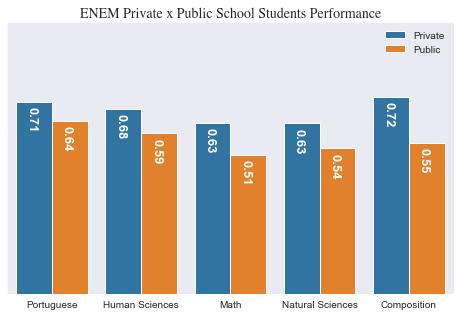

In [379]:
# To end the task, let's plot a bar chart exposing the grade differences.
# Private school students outperform the others in ENEM's every single subject.
import seaborn as sns
plt.figure(figsize = (8, 5))
sns.set_style('dark')
bars = sns.barplot(x = 'Subject', y = 'Avg Grade' ,hue = 'School Type',data = grades)

# Setting the aesthetic aspects of the chart.
bars.set_title('ENEM Private x Public School Students Performance', fontfamily = 'Times' ,fontsize = 14, pad = 5)
bars.set(xlabel = None, ylabel = None, yticks = [], ylim = [0,1], 
         xticklabels =['Portuguese', 'Human Sciences', 'Math', 'Natural Sciences', 'Composition'] )

for i in range(0, len(grades), 2):
    plt.text( (i/2)-0.3 , grades.iloc[i, 2] - 0.1, f'{grades.iloc[i, 2]:.2f}', rotation = 270, color = 'white',
            fontsize = 13, weight = 'bold')
    
for i in range(1, len(grades), 2):
    plt.text( (i/2)-0.4 , grades.iloc[i, 2] - 0.1, f'{grades.iloc[i, 2]:.2f}', rotation = 270, color = 'white',
             fontsize = 13,weight = 'bold')
plt.legend(loc = 'upper right', frameon = False);

<div>
<h1 style = 'font-size:30px'> 
    <strong>Task 4</strong>
        </h1>
    
</div>

<div>
    <ul style = 'font-size:20px'>
        <li>Here we'll perform a hypothesis test that will address the goal of this task.
        </li>
        
        <li> Null Hypothesis: The ENEM average performance from capital cities students is the SAME as the one from rural area students.
        </li>
        
        <li> Alternative Hypothesis: The ENEM average performance from capital cities students is NOT THE SAME as the one from rural area students.
        </li>
        
        <li>First of all we need to be able to segregate the students who live in state capitals from the ones who live in the rural areas.
        </li>
        
    </ul>
    </div>

In [380]:
# To tell Python which cities are the state capitals I've imported this table found on Wikipedia.
capital_cities = (pd.read_html('https://en.wikipedia.org/wiki/Federative_units_of_Brazil')[1][['Code', 'Capital']]
                 .set_index('Code'))
capital_cities.head()

,Capital
Code,
AC,Rio Branco
AL,Maceió
AP,Macapá
AM,Manaus
BA,Salvador


In [381]:
# Creating a list containing all the capital cities names.
capital_cities = list(capital_cities['Capital'])
capital_cities

['Rio Branco',
 'Maceió',
 'Macapá',
 'Manaus',
 'Salvador',
 'Fortaleza',
 'Brasília',
 'Vitória',
 'Goiânia',
 'São Luís',
 'Cuiabá',
 'Campo Grande',
 'Belo Horizonte',
 'Belém',
 'João Pessoa',
 'Curitiba',
 'Recife',
 'Teresina',
 'Rio de Janeiro',
 'Natal',
 'Porto Alegre',
 'Porto Velho',
 'Boa Vista',
 'Florianópolis',
 'São Paulo',
 'Aracaju',
 'Palmas']

In [382]:
# First of all we need to be able to divide the students who live in state capitals from the ones 
# who live in the rural areas.
# With the list on our hands it will be possible to segregate the data accodingly to our desires.
capital_students = enem[(enem['NO_MUNICIPIO_RESIDENCIA'].isin(capital_cities)) & (enem['TP_ST_CONCLUSAO'] == 2 ) ]
rural_students = enem[~(enem['NO_MUNICIPIO_RESIDENCIA'].isin(capital_cities)) & (enem['TP_ST_CONCLUSAO'] == 2 )]

In [390]:
# Obtaining the mean average from every single student in both of the groups.
capital_mean = capital_students['Avg Grade']
rural_mean = rural_students['Avg Grade']

In [391]:
# Pre-test requirement: ensure that the variances of 'capital_mean' and 'rural_mean' are equal.

# Since the ratio between the highest and the lowest variance is less than four, we can assume that the variances
# are the same, meaning that we do not have to perform a Welch's t-test.
capital_mean.var() / rural_mean.var()

1.1772680534969158

In [392]:
#  We are going to set the Significance Level as 5%.
from scipy.stats import ttest_ind
pvalue = ttest_ind(capital_mean.sample(1000), rural_mean.sample(1000))[1]
print(f'{pvalue:.2f}')

0.00


<div>
    <ul style = 'font-size:20px'>
        <li> The p-value obtained was less than 5%. Hence, we can accept the Alternative Hypothesis.
        </li>

<h1 style = 'font-size:30px'> Task 5</h1>

<div>
    <ul style = 'font-size:20px'>
        <li> You can interpret this task as a complement of task 3. Its main goal is going to expose the average performance from students according to the economic layer to which they pertain. Do the poorer participants have worse grades than their richer counterparts?
    </ul>
    </div>

In [393]:
# Each economic layer is labeled by a letter. So, in this cell, I'll show you the actual correspondence of the codes.
economic_layers = pd.read_excel('Dicion rio_Microdados_Enem_2019.xlsx', sheet_name = 'MICRODADOS_ENEM_2019', 
                    usecols = [2,3],index_col = 0).iloc[334:351]
economic_layers.rename(columns = {'Unnamed: 3':'Revenue Range'}, inplace =  True)
economic_layers['Revenue Range'].replace({'Até':'-', 'até': '-' , 'De': '', 'Nenhuma renda.':'No revenue', '  ':''},
                                         regex = True, inplace = True)
economic_layers['Revenue Range'].replace({'- R\$ 998,00.':'≤ R$ 998,00', 'Mais de':'≥'}, regex = True, inplace = True)
economic_layers['Revenue Range'] = economic_layers['Revenue Range'].str.lstrip()
economic_layers = economic_layers.to_dict()['Revenue Range']
economic_layers

{'A': 'No revenue',
 'B': '≤ R$ 998,00',
 'C': 'R$ 998,01 - R$ 1.497,00.',
 'D': 'R$ 1.497,01 - R$ 1.996,00.',
 'E': 'R$ 1.996,01 - R$ 2.495,00.',
 'F': 'R$ 2.495,01 - R$ 2.994,00.',
 'G': 'R$ 2.994,01 - R$ 3.992,00.',
 'H': 'R$ 3.992,01 - R$ 4.990,00.',
 'I': 'R$ 4.990,01 - R$ 5.988,00.',
 'J': 'R$ 5.988,01 - R$ 6.986,00.',
 'K': 'R$ 6.986,01 - R$ 7.984,00.',
 'L': 'R$ 7.984,01 - R$ 8.982,00.',
 'M': 'R$ 8.982,01 - R$ 9.980,00.',
 'N': 'R$ 9.980,01 - R$ 11.976,00.',
 'O': 'R$ 11.976,01 - R$ 14.970,00.',
 'P': 'R$ 14.970,01 - R$ 19.960,00.',
 'Q': '≥ R$ 19.960,00.'}

Text(0.5, 1.0, 'Overall Performance per Economic Class')

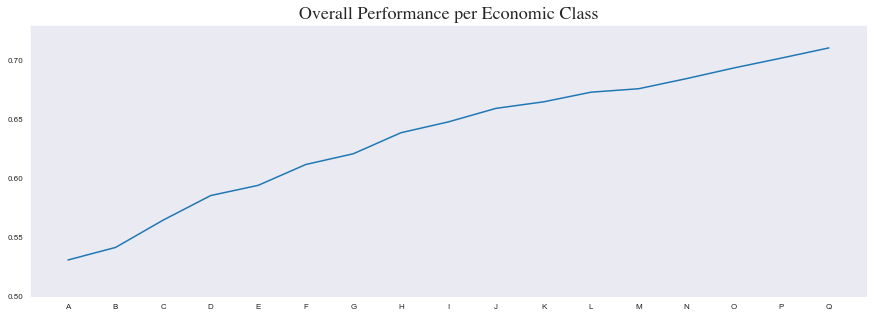

In [395]:
# Firstly, we ought to group the economic classes along their students average performance.
gp = enem.groupby(['Q006'])['Avg Grade'].mean()

# Plotting the desired chart.
gp.plot(kind = 'line', figsize = (15, 5),
                                    fontsize = 8, xlabel = '', ylim = [0.5 , 0.73], xticks = range(len(gp.index)))
plt.title('Overall Performance per Economic Class', fontsize = 18, fontfamily = 'Times')

<h1 style = 'font-size:40px'> Final Thoughts</h1>

<div>
    
    <ul style = 'font-size:20px'>
        <li> With that, we've completed our project! I hope you've find it interesting! If you do so, please check out my social media accounts, such as <a href = 'https://www.linkedin.com/in/felipe-veiga-9a59501bb/'> LinkedIn</a>, <a href = 'https://github.com/felipesveiga' >GitHub</a> and <a href = 'https://medium.com/@felipesveiga'> Medium!</a>
        </li>
    </ul>
    
</div>